In [290]:
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc
)

In [ ]:
# Cargar test data
df = pd.read_csv("../../data/processed/SPLV_clean.csv", parse_dates=["Date"])
test_df = df[df["Date"] >= "2025-03-01"]
X_test = test_df.drop(columns=["target", "Close", "Open", "High", "Low", "Date"])
y_test = test_df["target"]

# Cargar modelos guardados
model_names = ["DecisionTree", "RandomForest", "AdaBoost", "GradientBoosting", "LightGBM", "XGBoost"]
models = {}
for name in model_names:
    path = f"../../models/SPLV_{name}.pkl"
    if os.path.exists(path):
        models[name] = joblib.load(path)

In [292]:
summary = []
threshold = 0.55

for model_name, model in models.items():
    if model_name == "XGBoost":
        y_proba = model.predict_proba(X_test)[:, 1]
        y_pred = (y_proba > threshold).astype(int)
    else:
        y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="macro")
    rec = recall_score(y_test, y_pred, average="macro")
    f1 = f1_score(y_test, y_pred, average="macro")

    summary.append({
        "Model": model_name,
        "Accuracy": round(acc, 4),
        "Precision (Macro)": round(prec, 4),
        "Recall (Macro)": round(rec, 4),
        "F1-score (Macro)": round(f1, 4)
    })

df_summary = pd.DataFrame(summary)
print(df_summary.sort_values(by="Accuracy", ascending=False))

              Model  Accuracy  Precision (Macro)  Recall (Macro)  \
3  GradientBoosting    0.6786             0.8269          0.5909   
5           XGBoost    0.6786             0.7083          0.6070   
0      DecisionTree    0.6429             0.6257          0.6257   
1      RandomForest    0.6429             0.6257          0.6257   
2          AdaBoost    0.6071             0.5625          0.5321   
4          LightGBM    0.5357             0.6000          0.5856   

   F1-score (Macro)  
3            0.5492  
5            0.5902  
0            0.6257  
1            0.6257  
2            0.4992  
4            0.5303  


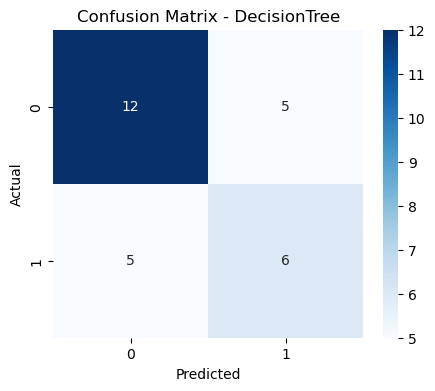

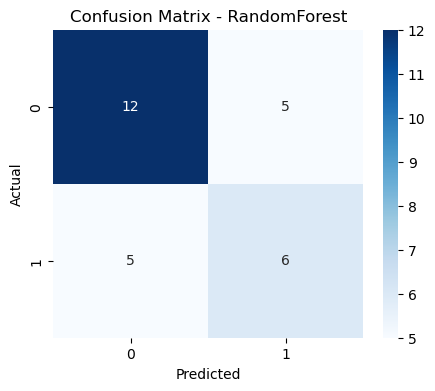

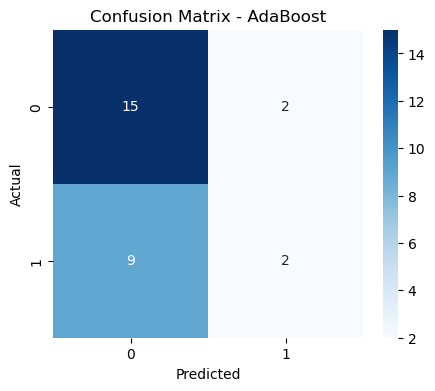

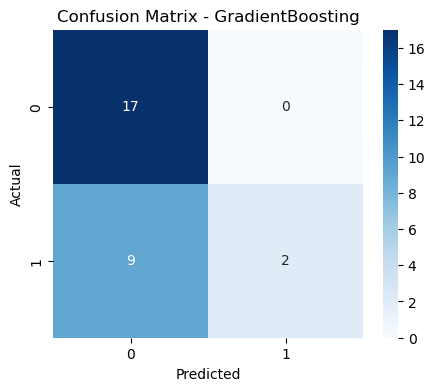

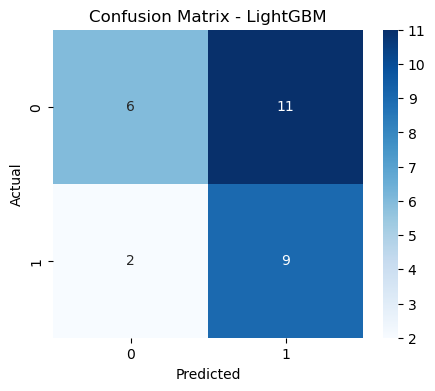

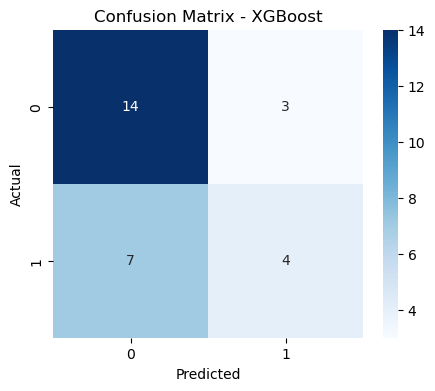

In [293]:
for model_name, model in models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

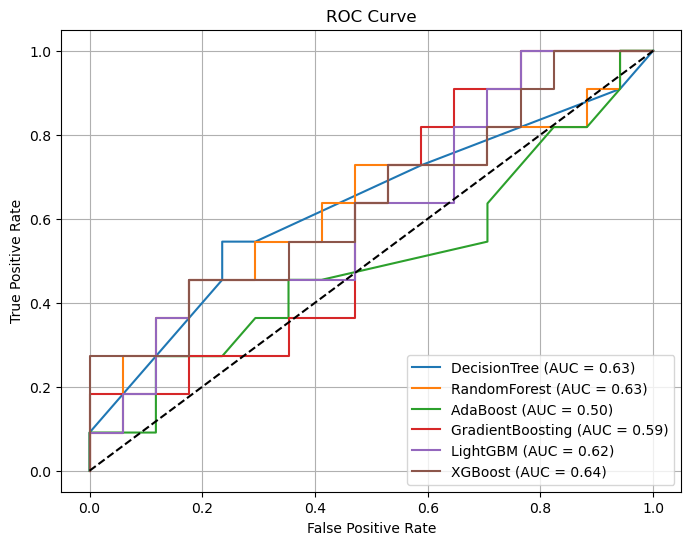

In [294]:
plt.figure(figsize=(8, 6))
for model_name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


📌 Evaluación de XGBoost con umbral = 0.55
Confusion Matrix:
[[16  1]
 [ 8  3]]
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.94      0.78        17
           1       0.75      0.27      0.40        11

    accuracy                           0.68        28
   macro avg       0.71      0.61      0.59        28
weighted avg       0.70      0.68      0.63        28



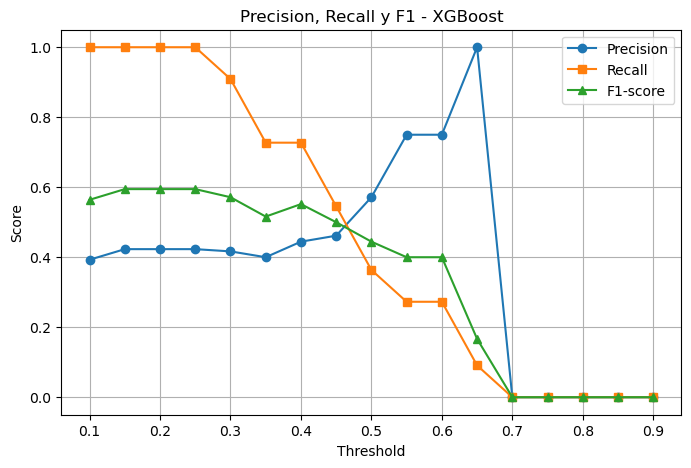


📌 Evaluación de RandomForest con umbral = 0.55
Confusion Matrix:
[[15  2]
 [ 7  4]]
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.88      0.77        17
           1       0.67      0.36      0.47        11

    accuracy                           0.68        28
   macro avg       0.67      0.62      0.62        28
weighted avg       0.68      0.68      0.65        28



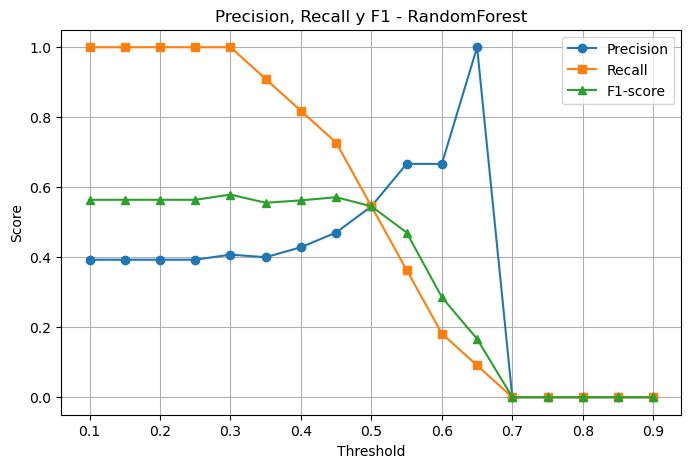


📌 Evaluación de GradientBoosting con umbral = 0.55
Confusion Matrix:
[[17  0]
 [ 9  2]]
Classification Report:
              precision    recall  f1-score   support

           0       0.65      1.00      0.79        17
           1       1.00      0.18      0.31        11

    accuracy                           0.68        28
   macro avg       0.83      0.59      0.55        28
weighted avg       0.79      0.68      0.60        28



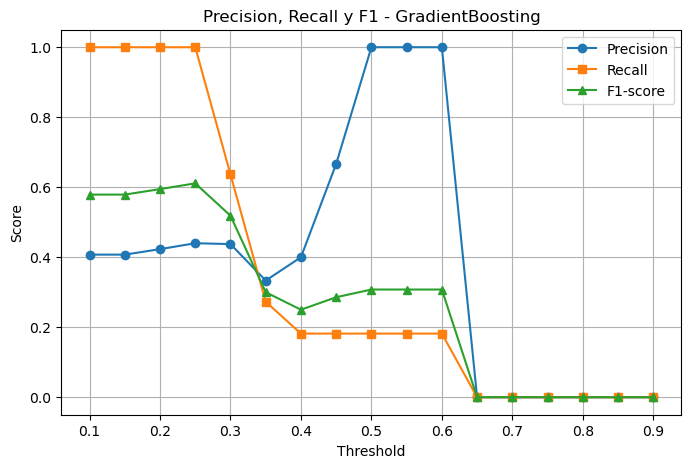

In [295]:
for model_key, th in [("XGBoost", 0.55), ("RandomForest", 0.55), ("GradientBoosting", 0.55)]:
    if model_key in models:
        model = models[model_key]
        y_proba = model.predict_proba(X_test)[:, 1]
        y_pred_custom = (y_proba > th).astype(int)
        
        print(f"\n📌 Evaluación de {model_key} con umbral = {th}")
        print("Confusion Matrix:")
        print(confusion_matrix(y_test, y_pred_custom))
        print("Classification Report:")
        print(classification_report(y_test, y_pred_custom))

        thresholds = np.arange(0.1, 0.91, 0.05)
        precisions = []
        recalls = []
        f1_scores = []

        for t in thresholds:
            y_pred = (y_proba > t).astype(int)
            precisions.append(precision_score(y_test, y_pred, zero_division=0))
            recalls.append(recall_score(y_test, y_pred, zero_division=0))
            f1_scores.append(f1_score(y_test, y_pred, zero_division=0))

        plt.figure(figsize=(8, 5))
        plt.plot(thresholds, precisions, label="Precision", marker="o")
        plt.plot(thresholds, recalls, label="Recall", marker="s")
        plt.plot(thresholds, f1_scores, label="F1-score", marker="^")
        plt.xlabel("Threshold")
        plt.ylabel("Score")
        plt.title(f"Precision, Recall y F1 - {model_key}")
        plt.legend()
        plt.grid(True)
        plt.show()

In [296]:
test_df["next_close"] = test_df["Close"].shift(-1)
for model_name, model in models.items():
    if not hasattr(model, "predict_proba"):
        continue
    test_error_df = test_df.copy()
    test_error_df["pred"] = model.predict(X_test)
    test_error_df["error"] = test_error_df["pred"] != test_error_df["target"]
    errores = test_error_df[test_error_df["error"] == True][["Date", "Close", "next_close", "target", "pred"]]
    print(f"\n🔍 Errores de clasificación para: {model_name}")
    print(errores.head(10))
    print(f"Total errores: {len(errores)} / {len(test_error_df)}")


🔍 Errores de clasificación para: DecisionTree
           Date      Close  next_close  target  pred
1020 2025-03-10  74.052200   72.744102       0     1
1021 2025-03-11  72.744102   71.925293       0     1
1023 2025-03-13  71.905327   72.674202       1     0
1028 2025-03-20  73.333244   72.813995       0     1
1032 2025-03-26  73.769997   74.070000       1     0
1034 2025-03-28  73.720001   74.720001       1     0
1036 2025-04-01  74.709999   74.769997       1     0
1038 2025-04-03  74.129997   69.989998       0     1
1041 2025-04-08  68.129997   71.129997       1     0
1042 2025-04-09  71.129997         NaN       0     1
Total errores: 10 / 28

🔍 Errores de clasificación para: RandomForest
           Date      Close  next_close  target  pred
1016 2025-03-04  73.662766   73.912399       1     0
1018 2025-03-06  73.453072   74.162033       1     0
1023 2025-03-13  71.905327   72.674202       1     0
1024 2025-03-14  72.674202   73.403145       1     0
1025 2025-03-17  73.403145   73.253

/var/folders/ws/xnp5l9k56zggyb_d7zfv75rm0000gn/T/ipykernel_872/4177943691.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["next_close"] = test_df["Close"].shift(-1)
